## **Libraries**

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
sns.set()

from scipy.cluster.hierarchy import dendrogram, linkage # For hierarchical clustering
from sklearn.cluster import KMeans                      # For K-means clustering
from sklearn.decomposition import PCA                   # For principal component analysis
from sklearn.preprocessing import StandardScaler        # For standardizing features

## **Data**

In [2]:
# Load raw data
df_segmentation = pd.read_csv(os.path.join("..", "data", "customer_data.csv"), index_col = 0)

## **Exploration**

In [3]:
# Check the first rows
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
# Descriptive statistics
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


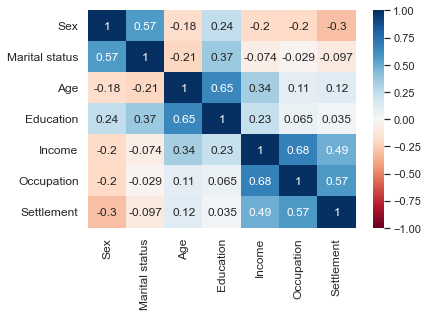

In [5]:
# Plot correlation coefficient for all the features in our data
sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = "RdBu",
               vmin = -1, 
               vmax = 1)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(rotation = 0, fontsize = 12)
plt.show()

Text(0, 0.5, 'Income')

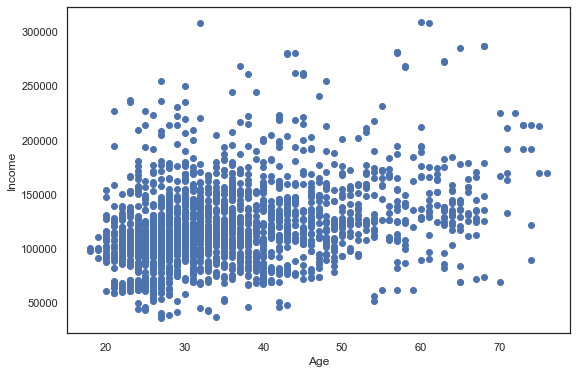

In [6]:
# Plot income against age 
plt.figure(figsize = (9, 6))
sns.set_style("white")
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Income", fontsize = 12)

## **Standardization**

In [7]:
# Standardize data so that all features have equal weight
scaler = StandardScaler()
df_segm_std = scaler.fit_transform(df_segmentation)

## **HCA**

In [8]:
# Perform hierarchical clustering 
hca = linkage(df_segm_std, method = "ward")

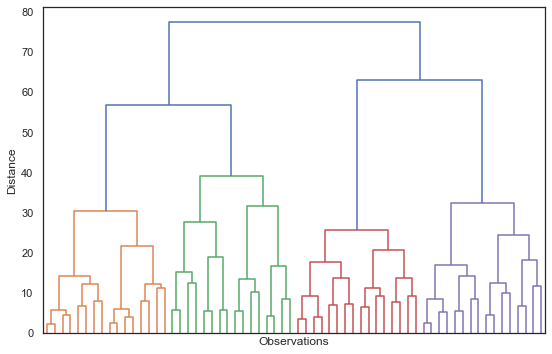

In [9]:
# Plot result matrix
plt.figure(figsize = (9, 6))
sns.set_style("white")
plt.xlabel("Observations", fontsize = 12)
plt.ylabel("Distance", fontsize = 12)
dendrogram(hca,
           truncate_mode = "level", # Truncate the dendrogram for better readability
           p = 5,                   # Shows only the last p merged clusters
           show_leaf_counts = False,
           no_labels = True,        # Omit showing the labels for each point
           leaf_font_size = 12)
plt.show()

## **K-Means**

In [10]:
# Perform K-means clustering
wcss = []                               # Within Cluster Sum of Squares (WCSS)
for i in range(1, 11):                  # The algoritm considers 1 to 10 clusters
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++", # Run the algortihm at many different starting points
                    random_state = 42)  # Set a random state for reproducibility
    kmeans.fit(df_segm_std)
    wcss.append(kmeans.inertia_)

c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  f"KMeans is known to have a memory leak on Windows "


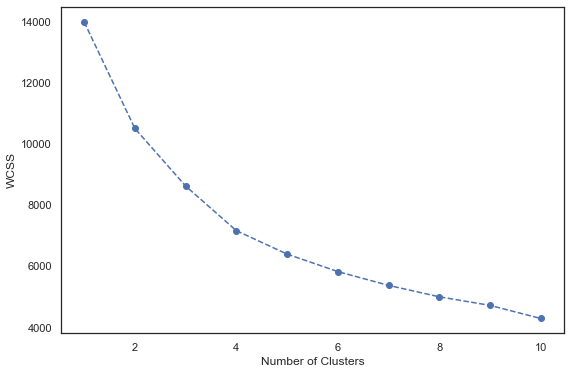

In [11]:
# Plot the WCSS for the different number of clusters
plt.figure(figsize = (9, 6))
sns.set_style("white")
plt.plot(range(1, 11), wcss, marker = "o", linestyle = "--")
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel("WCSS", fontsize = 12)
plt.show()

In [12]:
# Perform K-means with a fixed number of clusters
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
kmeans.fit(df_segm_std)

KMeans(n_clusters=4, random_state=42)

### **Results**

In [13]:
# Create a new data frame with the original features
df_kmeans = df_segmentation.copy()

# Add a new column with the assigned clusters for each point
df_kmeans["Segment K-Means"] = kmeans.labels_

In [14]:
# Calculate mean values for the clusters
df_analysis = df_kmeans.groupby(["Segment K-Means"]).mean()
df_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement
Segment K-Means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807


In [15]:
# Compute the size and proportions of the four clusters
df_analysis["N Obs"] = df_kmeans[["Segment K-Means", "Sex"]].groupby(["Segment K-Means"]).count()
df_analysis["Prop Obs"] = df_analysis["N Obs"] / df_analysis["N Obs"].sum()
df_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,N Obs,Prop Obs
Segment K-Means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [16]:
# Label the four clusters
df_analysis.rename({0:"well-off",
                    1:"fewer-opportunities",
                    2:"standard",
                    3:"career-focused"})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,N Obs,Prop Obs
Segment K-Means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
career-focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [17]:
# Add the segment labels to the table
df_kmeans["Labels"] = df_kmeans["Segment K-Means"].map({0:"well-off",
                                                        1:"fewer-opportunities",
                                                        2:"standard",
                                                        3:"career-focused"})

c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


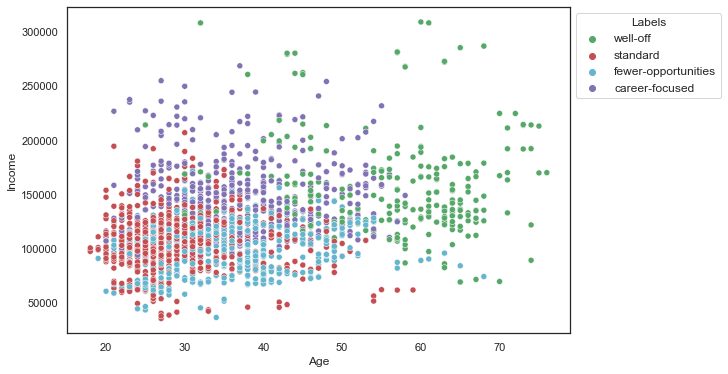

In [18]:
# Plot the results from the algorithm with different color for each cluster
x_axis = df_kmeans["Age"]
y_axis = df_kmeans["Income"]
plt.figure(figsize = (9, 6))
sns.set_style("white")
sns.scatterplot(x_axis, y_axis, hue=df_kmeans["Labels"], palette=["g", "r", "c", "m"])
legend = plt.legend(title="Labels", loc="upper left", bbox_to_anchor=(1, 1), fontsize = 12)
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Income", fontsize = 12)
plt.show()

## **PCA**

In [19]:
# Employ PCA to find a subset of components that explain the variance in the data
pca = PCA()
pca.fit(df_segm_std)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance')

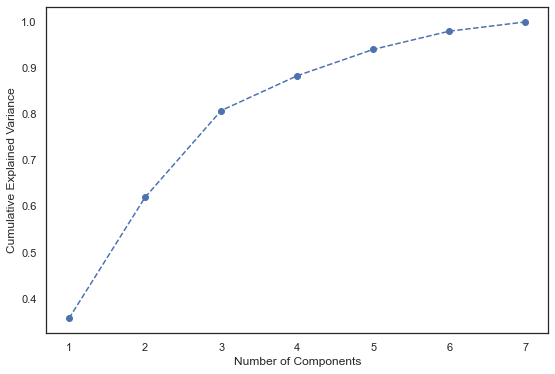

In [20]:
# Plot the cumulative variance explained by total number of components
plt.figure(figsize = (9, 6))
sns.set_style("white")
plt.plot(range(1, 8), pca.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--")
plt.xlabel("Number of Components", fontsize = 12)
plt.ylabel("Cumulative Explained Variance", fontsize = 12)

In [21]:
# Fit the model in our data with the selected number of components
pca = PCA(n_components = 3)
pca.fit(df_segm_std)

PCA(n_components=3)

### **Results**

In [22]:
# Show the loadings that are the coefficients applied to the variables to determine the principal components
df_pca = pd.DataFrame(data = pca.components_,
                      columns = df_segmentation.columns.values,
                      index = ["Component 1", "Component 2", "Component 3"])
df_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


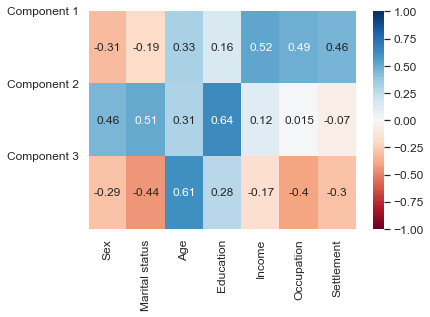

In [23]:
# Plot principal components against original features
heatmap = sns.heatmap(df_pca,
                      vmin = -1,
                      vmax = 1,
                      cmap = "RdBu",
                      annot = True)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize = 12)
plt.xticks(fontsize = 12)
plt.yticks([0, 1, 2],
           ["Component 1", "Component 2", "Component 3"],
           rotation = 0,
           fontsize = 12)
plt.show()

In [24]:
# Store principal components scores
scores_pca = pca.transform(df_segm_std)
scores_pca

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

## **K-Means (PCA)**

In [25]:
# Perform K-means clustering using the principal components scores
wcss = []
for i in range(1, 11):                      # The algoritm considers 1 to 10 clusters
    kmeans_pca = KMeans(n_clusters = i,
                        init = "k-means++", # Run the algortihm at many different starting points
                        random_state = 42)  # Set a random state for reproducibility
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  f"KMeans is known to have a memory leak on Windows "


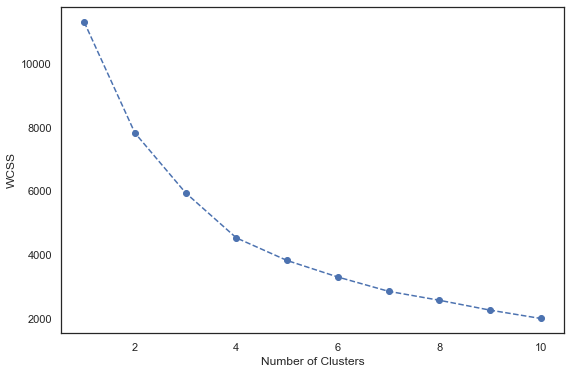

In [26]:
# Plot the WCSS for the K-means PCA model
plt.figure(figsize = (9, 6))
plt.plot(range(1, 11), wcss, marker = "o", linestyle = "--")
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel("WCSS", fontsize = 12)
plt.show()

In [27]:
# Perform K-means with the chosen number of clusters
kmeans_pca = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

### **Results**

In [28]:
# Create a new data frame with the original features and add the PCA scores and assigned clusters
df_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans.columns.values[-3: ] = ["Component 1", "Component 2", "Component 3"]

In [29]:
# Add a column that contains the PCA K-means clustering labels
df_pca_kmeans["Segment K-Means PCA"] = kmeans_pca.labels_
df_pca_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,Component 1,Component 2,Component 3,Segment K-Means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1


In [30]:
# Calculate the means of all the features by segments
df_pca_freq = df_pca_kmeans.groupby(["Segment K-Means PCA"]).mean()
df_pca_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,Component 1,Component 2,Component 3
Segment K-Means PCA,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


In [31]:
# Calculate the size of each cluster and its proportion to the entire data set
df_pca_freq["N Obs"] = df_pca_kmeans[["Segment K-Means PCA", "Sex"]].groupby(["Segment K-Means PCA"]).count()
df_pca_freq["Prop Obs"] = df_pca_freq["N Obs"] / df_pca_freq["N Obs"].sum()
df_pca_freq = df_pca_freq.rename({0:"standard", 1:"career-focused", 2:"fewer-opportunities", 3:"well-off"})
df_pca_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-Means PCA,,,,,,,,,,,,
standard,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
career-focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
fewer-opportunities,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
well-off,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


In [32]:
# Add a column that contains labels for each segment
df_pca_kmeans["Legend"] = df_pca_kmeans["Segment K-Means PCA"].map({0:"standard",
                                                                    1:"career-focused",
                                                                    2:"fewer-opportunities",
                                                                    3:"well-off"})
df_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement,Component 1,Component 2,Component 3,Segment K-Means PCA,Legend
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3,well-off
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0,standard
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2,fewer-opportunities
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1,career-focused
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1,career-focused
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2,fewer-opportunities
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0,standard
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2,fewer-opportunities
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0,standard


c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


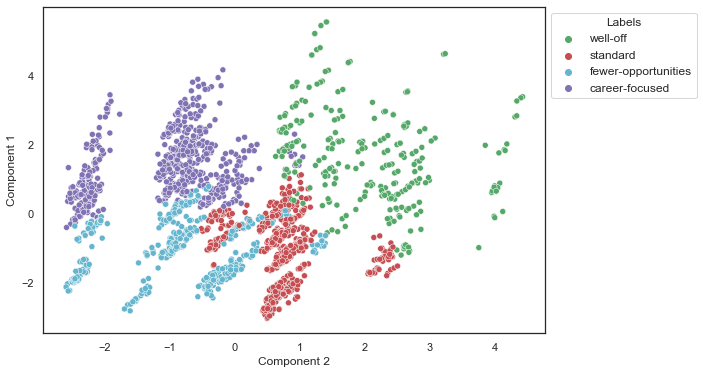

In [33]:
# Plot clusters by first and second components
x_axis = df_pca_kmeans["Component 2"]
y_axis = df_pca_kmeans["Component 1"]
plt.figure(figsize = (9, 6))
sns.scatterplot(x_axis, y_axis, hue = df_pca_kmeans["Legend"], palette = ["g", "r", "c", "m"])
plt.legend(title = "Labels", loc = "upper left", bbox_to_anchor = (1, 1), fontsize = 12)
plt.xlabel("Component 2", fontsize = 12)
plt.ylabel("Component 1", fontsize = 12)
plt.show()

c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


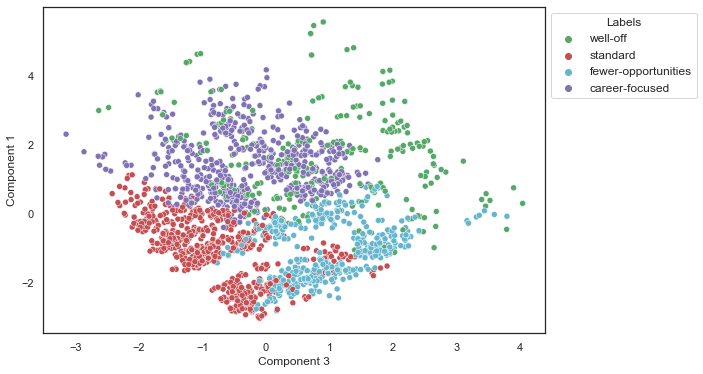

In [34]:
# Plot clusters by first and third components
x_axis = df_pca_kmeans["Component 3"]
y_axis = df_pca_kmeans["Component 1"]
plt.figure(figsize = (9, 6))
sns.scatterplot(x_axis, y_axis, hue = df_pca_kmeans["Legend"], palette = ["g", "r", "c", "m"])
plt.legend(title = "Labels", loc = "upper left", bbox_to_anchor = (1, 1), fontsize = 12)
plt.xlabel("Component 3", fontsize = 12)
plt.ylabel("Component 1", fontsize = 12)
plt.show()

c:\Users\luca.saccilotto\AppData\Local\miniconda3\envs\customer-segmentation\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


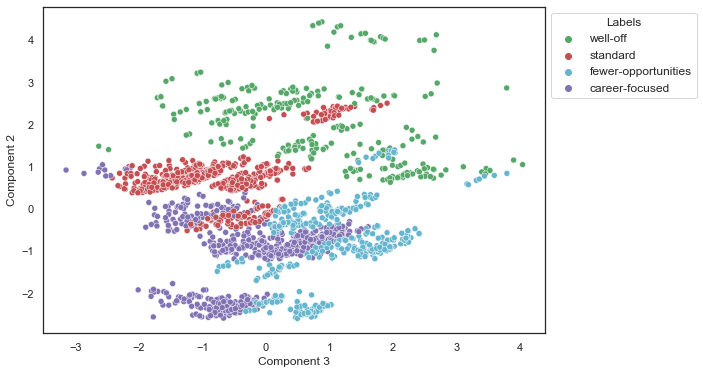

In [35]:
# Plot clusters by third and second components
x_axis = df_pca_kmeans["Component 3"]
y_axis = df_pca_kmeans["Component 2"]
plt.figure(figsize = (9, 6))
sns.scatterplot(x_axis, y_axis, hue = df_pca_kmeans["Legend"], palette = ["g", "r", "c", "m"])
plt.legend(title = "Labels", loc = "upper left", bbox_to_anchor = (1, 1), fontsize = 12)
plt.xlabel("Component 3", fontsize = 12)
plt.ylabel("Component 2", fontsize = 12)
plt.show()

## **Saving**

In [36]:
# Save the items needed for analytics and export them as pickle objects
pickle.dump(kmeans_pca, open(os.path.join("utils", "kmeans_pca.pickle"), "wb"))
pickle.dump(pca, open(os.path.join("utils", "pca.pickle"), "wb"))
pickle.dump(scaler, open(os.path.join("utils", "scaler.pickle"), "wb"))